# KDTree Test

One of the slowest parts (now that multiprocessing is working) is the pruning of extraneous peaks. It seems to me that there are 3 ways we can make this go faster.

1. Brute force (current implementation) + `multiprocessing`
2. Dynamic programming, we can build up a solution one peak at a time
3. We could use KDTrees to find nearest neighbors quickly and then brute force our way through those

The last two seem to be the best choices, from a learning prospective an elegance prospective and probably and efficiency prospective.

One important thing to note is that the highest amplitude peak should be analyzed first

In [9]:
import os
import numpy as np
import itertools as itt
from numpy.linalg import norm
from scipy.spatial import cKDTree

%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib.patches import Circle

```python
def prune_blobs(blobs, diameter):
    """Original implementation of method, taken from skimage.
    This is a simple, and naive brute force calculation.
    """
    # assumes blobs have structure of y0, x0, width, amp
    # make a copy of blobs otherwise it will be changed
    temp_blobs = blobs.copy()
    # cycle through all possible pairwise cominations of blobs
    for blob1, blob2 in itt.combinations(temp_blobs, 2):
        # take the norm of the difference in positions and compare
        # with diameter
        if norm((blob1 - blob2)[0:2]) < diameter:
            # compare intensities and use the third column to keep
            # track of which blobs to toss
            if blob1[3] > blob2[3]:
                blob2[3] = -1
            else:
                blob1[3] = -1

    # set internal blobs array to blobs_array[blobs_array[:, 2] > 0]
    new_blobs = np.array([
        a for b, a in zip(temp_blobs, blobs) if b[3] > 0
    ])

    # Return a copy of blobs incase user wants a onliner
    return new_blobs
```

In [10]:
def prune_blobs(blobs, diameter):
    """Original implementation of method, taken from skimage.
    This is a simple, and naive brute force calculation.
    """
    # assumes blobs have structure of y0, x0, width, amp
    # make a copy of blobs otherwise it will be changed
    temp_blobs = blobs.copy()
    dead_blobs = set()
    # cycle through all possible pairwise cominations of blobs
    for blob1, blob2 in itt.combinations(temp_blobs, 2):
        # take the norm of the difference in positions and compare
        # with diameter
        if norm((blob1 - blob2)[:2]) < diameter:
            # compare intensities and use the third column to keep
            # track of which blobs to toss
            if blob1[3] > blob2[3]:
                dead_blobs.add(tuple(blob2[:2]))
                blob2[3] = -1
            else:
                dead_blobs.add(tuple(blob1[:2]))
                blob1[3] = -1

    # set internal blobs array to blobs_array[blobs_array[:, 2] > 0]
    new_blobs = np.array([
        a for b, a in zip(temp_blobs, blobs) if b[3] > 0
    ])

    # Return a copy of blobs incase user wants a onliner
    return new_blobs, dead_blobs

In [25]:
#KDTree returns _nodes_ which interfere
def new_puner(blobs, radius):
    """This one uses KDTrees to mimize the search space"""
    # create the tree
    kdtree = cKDTree(blobs[:,:2])
    # query all pairs of points within diameter of each other
    list_of_conflicts = list(kdtree.query_pairs(radius))
    # sort the collisions by max amplitude of the pair
    # we want to deal with collisions between the largest
    # blobs and nearest neighbors first:
    # Consider the following sceneario in 1D
    # A-B-C
    # are all the same distance and colliding with amplitudes
    # A > B > C
    # if we start with the smallest, both B and C will be discarded
    # If we start with the largest, only B will be
    list_of_conflicts.sort(
        key = lambda x: max(blobs[x[0], -1], blobs[x[1], -1]),
        reverse = True
    )
    # indices of pruned blobs
    pruned_blobs = set()
    for a, b in list_of_conflicts:
        # see if we've already pruned one of the pair
        if (a not in pruned_blobs) and (b not in pruned_blobs):
            # compare based on amplitude
            if blobs[a,-1] > blobs[b,-1]:
                pruned_blobs.add(b)
            else:
                pruned_blobs.add(a)
    # generate the pruned list
    pruned_blobs_list = {(blobs[i, 0], blobs[i, 1]) for i in pruned_blobs}
    # and the new list
    new_blobs = blobs[[i for i in range(len(blobs)) if i not in pruned_blobs]]
    return new_blobs, pruned_blobs_list 

In [11]:
def plotter(data, diameter):
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.set_aspect("equal")
    ax.scatter(data[:, 1], data[:, 0],100, c=data[:,-1], cmap="viridis")
    for y, x, s, a in data:
        ax.add_patch(Circle((x, y), diameter, fill=False))
    return fig, ax

In [21]:
# make fake data
data = np.array([(np.random.random_sample(),
        np.random.random_sample(),
        np.random.chisquare(2),
        np.random.poisson(1000))
        for _ in range(1000)])
data = data[data[:, 3].argsort()][::-1]

In [38]:
print("old method time ",end="")
%time pruned_data, dead_data = prune_blobs(data, 0.05)
print("new method time ",end="")
%time new_pruned_data, new_dead_data = new_puner(data, 0.05)
print("old method pruned", len(dead_data))
print("new method pruned", len(new_dead_data))

old method time Wall time: 3.11 s
new method time Wall time: 9 ms
old method pruned 795
new method pruned 795


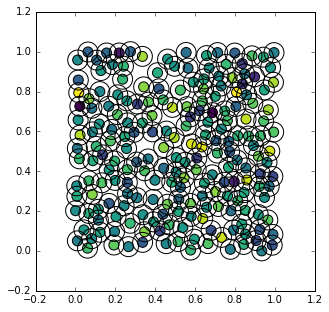

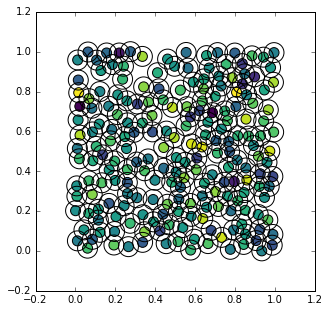

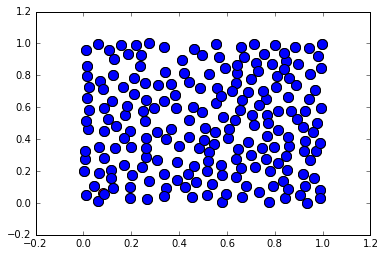

In [39]:
plotter(pruned_data, 0.05)
plotter(new_pruned_data, 0.05)
fig, ax = plt.subplots(1,1)
ax.scatter(pruned_data[:, 1], pruned_data[:, 0],100, c="r")
ax.scatter(new_pruned_data[:, 1], new_pruned_data[:, 0],100, c="b")

In [36]:
np.allclose(pruned_data, new_pruned_data)

True

In [29]:
real_data = np.loadtxt(os.path.join("..","fixtures","blobs.txt"),
                       delimiter=",", skiprows=1)

In [30]:
prepruned_data = np.loadtxt(os.path.join("..","fixtures","blobspruned10.txt"),
                       delimiter=",", skiprows=1)

In [31]:
print("old method time ",end="")
%time pruned_data, dead_data = prune_blobs(real_data, 10)
print("new method time ",end="")
%time new_pruned_data, new_dead_data = new_puner(real_data, 10)
print("old method pruned", len(dead_data))
print("new method pruned", len(new_dead_data))

old method time Wall time: 11.1 s
new method time Wall time: 2 ms
old method pruned 105
new method pruned 111


In [32]:
np.allclose(pruned_data, prepruned_data)

True